In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import random

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_table('data/steel_alloying.csv', sep=';', index_col=0, decimal=',')
data.head()

,nplv,DT,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,г6837?3<87?,2070-06-21 00:14:00,Э76ХФ,Р65,29.0,45.366667,24.400000,41.033333,NaN,0.456460,...,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
1,г683863<886,2070-06-21 01:07:00,Э76ХФ,Р65,26.0,44.066667,13.866667,44.066667,NaN,0.359285,...,0.14,2.2,NaN,NaN,59.3,0.6,4.1,0.11,2.3,NaN
2,г683863<887,2070-06-21 02:00:00,Э76ХФ,Р65,24.0,43.350000,17.950000,43.350000,NaN,0.331665,...,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
3,г683863<888,2070-06-21 02:58:00,Э76ХФ,Р65,17.0,46.183333,19.816667,46.183333,NaN,0.377945,...,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
4,г683863<889,2070-06-21 03:50:00,Э76ХФ,Р65,20.0,48.500000,17.033333,48.500000,NaN,0.389875,...,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN


In [3]:
# размер датасета
data.shape

(7041, 84)

In [4]:
# data.info()

In [5]:
# data['ПРОФИЛЬ'].value_counts() 
# Значения данного столбца скорее относятся к форме сплава, чем его сотставу. 

In [6]:
# Удаляемя не информативные признаки 
data.drop(['nplv', 'DT', 'ПРОФИЛЬ'], axis=1, inplace=True)

In [7]:
# data['МАРКА'].value_counts()

Выборка по маркам сталей не сбалонсированная, сформируем три класса сталей Э76ХФ, Э90ХАФ и другие - объединение остальных классов.

In [8]:
marka_dict = {'Э76ХФ': 'Э76ХФ', 'Э90ХАФ': 'Э90ХАФ'}

for marka in data['МАРКА'].value_counts().index:
    if not (marka in ['Э76ХФ', 'Э90ХАФ']):
        marka_dict.update({marka: 'другие'})
        
data['МАРКА']  = data['МАРКА'].map(marka_dict)

In [9]:
data['МАРКА'].value_counts()

Э76ХФ     4953
Э90ХАФ    1384
другие     704
Name: МАРКА, dtype: int64

## Переменные времени

In [10]:
data.iloc[:, 1:5].describe()

,t вып-обр,t обработка,t под током,t продувка
count,6444.000000,6440.000000,6440.000000,6444.000000
mean,26.492241,46.194099,21.010523,46.063051
std,14.842045,9.878727,4.758272,9.625492
min,-1.000000,4.350000,2.816667,4.350000
25%,14.000000,42.350000,18.033333,42.216667
50%,25.000000,44.683333,20.500000,44.550000
75%,37.000000,47.550000,23.300000,47.516667
max,98.000000,294.083333,67.583333,251.000000


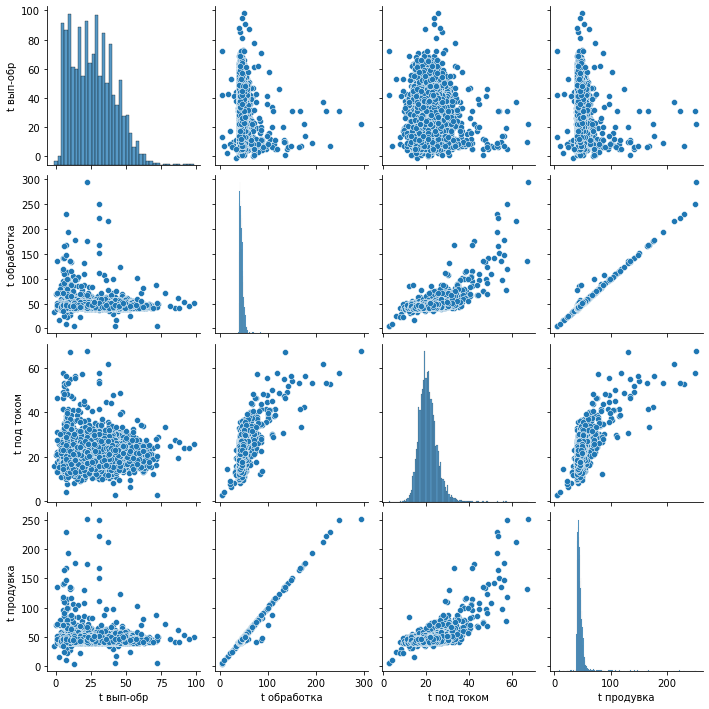

In [11]:
sns.pairplot(data.iloc[:, 1:5])

##  Удаление полупустых строчек и столбцев

### Строки

In [12]:
null_values = pd.DataFrame({'кол-во пропуск' :data.iloc[:, :].isna().sum()})
null_values['per'] = (null_values.iloc[:, 0] * 100 / len(data)).apply(lambda x: round(x, 2))
null_values.value_counts().head(5) # количесвто колонок, в которых одинаковое кол-во пропусков

кол-во пропуск  per  
597             8.48     37
598             8.49      4
601             8.54      4
2299            32.65     4
5652            80.27     2
dtype: int64

In [13]:
# Проверяем, что в 37 колонках, в которых отстутвует 597 значений, пропуски относятся к одним и тем же строкам.
empty_columns = data[null_values[null_values.per == 8.48].index].T.isna().sum() 
(empty_columns == 37).sum()

597

In [14]:
data[null_values[null_values.per == 8.48].index].columns
# в этих строках отутсвуют основные переменные, по которым мы анализуем наши данные (химшлак последний CaO, FeO, MnO, R)
# значит можем эти строки удалять

Index(['t вып-обр', 't продувка', 'произв жидкая сталь',
       'произв количество обработок', 'произв  количество плавок',
       'произв количество плавок (цел)', 'химсталь первый Al_1',
       'химсталь первый C_1', 'химсталь первый Cr_1', 'химсталь первый Cu_1',
       'химсталь первый Mn_1', 'химсталь первый Ni_1', 'химсталь первый P_1',
       'химсталь первый S_1', 'химсталь первый Si_1', 'химсталь первый Ti_1',
       'химсталь первый V_1', 'химсталь последний Al', 'химсталь последний C',
       'химсталь последний Cr', 'химсталь последний Cu',
       'химсталь последний Mn', 'химсталь последний Mo',
       'химсталь последний Ni', 'химсталь последний P', 'химсталь последний S',
       'химсталь последний Si', 'химсталь последний Ti',
       'химсталь последний V', 'химшлак первый CaO_1', 'химшлак первый FeO_1',
       'химшлак первый MnO_1', 'химшлак первый R_1', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MnO',
       'химшлак последний R'],
  

In [15]:
data.drop(empty_columns[empty_columns == 37].index, axis=0, inplace=True)
data.shape

(6444, 81)

### Столбцы

In [16]:
def df_null_values(df):
    null_values = pd.DataFrame({'кол-во пропуск' :df.isna().sum()})
    null_values['per'] = (null_values.iloc[:, 0] * 100 / len(df)).apply(lambda x: round(x, 3))
    return null_values

In [17]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False).head(17)

,кол-во пропуск,per
ферспл FeSi-75,6439,99.922
сыпуч кокс. мелочь (сух.),6437,99.891
сыпуч кварцит,6431,99.798
ферспл FeMo,6411,99.488
ферспл Ni H1 пласт.,6362,98.727
ферспл FeV азот.,6061,94.056
расход C пров.,5720,88.765
ферспл ферванит,5427,84.218
N2 (интенс.),5055,78.445
расход газ N2,5055,78.445


In [18]:
#удалим колонки, в которых больше 70 % пропусков 
data.drop(null_values[null_values.per > 70].index, axis=1, inplace=True)
data.shape

(6444, 71)

# Восстановление пропущенных значений

In [19]:
def brief_summary(series):
#     series.hist()
    plt.show();
    print(series.name, '\nМедиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(series.mean(), 3),\
                                                                         round(series.std(), 3),\
                                                                         series.median()))

In [20]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False).head(7)

,кол-во пропуск,per
химшлак последний SiO2,1702,26.412
химшлак последний Al2O3,1702,26.412
химшлак первый Al2O3_1,1702,26.412
химшлак первый SiO2_1,1702,26.412
сыпуч известь РП,1674,25.978
ПСН гр.,1195,18.544
чист расход Cr,561,8.706


In [21]:
# проверка, что нет  данных целевых переменных по одним и тем же строчкам
(data['химшлак последний SiO2'].isna() == data['химшлак первый Al2O3_1'].isna()).sum()
# пока что оставим эти пропуски
target_with_nan_col = ['химшлак последний SiO2', 'химшлак первый SiO2_1', 'химшлак первый Al2O3_1',  'химшлак последний Al2O3' ]


In [22]:
def description(df, columns):
    for name in columns:
        print(name, '\nПропущенных значений:', df[name].isna().sum(),\
              '(', round(df[name].isna().sum() * 100 / len(df[name]), 2)  ,'%)',
             '\nМедиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(df[name].mean(), 3),\
                                                                         round(df[name].std(), 3),\
                                                                         df[name].median()),\
              '\nУникальных значений: {}'.format(df[name].value_counts(dropna=False).count()), '\n')
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(221)
        plt.hist(df[name])
        plt.grid()
        plt.subplot(222)
        sns.boxplot(y=df[name])
        plt.show()

In [23]:
data.shape

(6444, 71)

In [24]:
df_first = data.copy()

## сыпуч известь РП

У данной переменной 26 % пропущенных значений. Попробуем восстановить их через внутриклассовые медианы значений

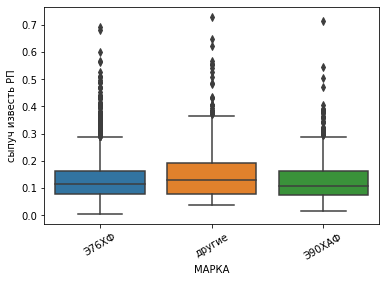

In [25]:
ax = sns.boxplot(data=df_first, y='сыпуч известь РП' , x='МАРКА')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);


Распределние не симметричное, с длинным правым хвостом, попробуем прологарифмировать эти значения, чтобы получить более симметричное распределение.

In [26]:
df_first['ln сыпуч известь РП'] = np.log(df_first['сыпуч известь РП'])

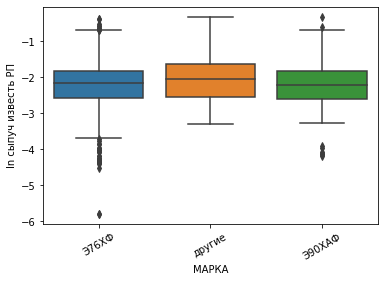

In [27]:
ax = sns.boxplot(data=df_first, y='ln сыпуч известь РП', x='МАРКА')
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [28]:
name = 'ln сыпуч известь РП' 
grouped = df_first[['МАРКА', name]].groupby('МАРКА')
CaO_ln = grouped[name].transform(lambda x: x.fillna(x.median()))

Посмотрим как изменится распределение "сыпуч известь РП" после подстановки пропущенных значений

In [29]:
brief_summary(np.exp(CaO_ln))

ln сыпуч известь РП 
Медиана: 0.116, Среднее значение: 0.128, Ср.откл:0.069


In [30]:
brief_summary(data['сыпуч известь РП'])

сыпуч известь РП 
Медиана: 0.11599999999999999, Среднее значение: 0.132, Ср.откл:0.08


In [31]:
# Пармаметры распредления почти не изменились. Все ок
data['сыпуч известь РП'] = np.exp(CaO_ln)

In [32]:
# data.isna().sum().sort_values(ascending=False)

## ПСН гр. 

In [33]:
data[['ПСН гр.', 'эл. энергия (интенс.)']].corr()

,ПСН гр.,эл. энергия (интенс.)
ПСН гр.,1.000000,0.459081
эл. энергия (интенс.),0.459081,1.000000


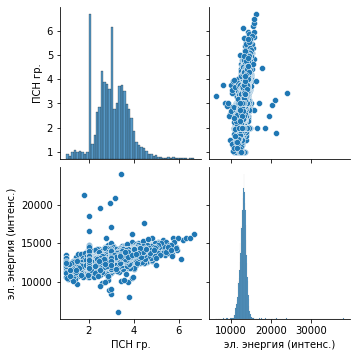

In [34]:
sns.pairplot(data[['ПСН гр.', 'эл. энергия (интенс.)']])

ПСН гр. хорошо коррелирует с "эл. энергия (интенс.)"

Удалим "ПСН гр." из датасета, так как он не очень информативен

In [35]:
data.drop('ПСН гр.', axis=1, inplace=True)

In [36]:
null_values = df_null_values(data)
data_with_nan = null_values[null_values.per != 0].sort_values('per', ascending = False)
data_with_nan.head(5)

,кол-во пропуск,per
химшлак последний SiO2,1702,26.412
химшлак последний Al2O3,1702,26.412
химшлак первый SiO2_1,1702,26.412
химшлак первый Al2O3_1,1702,26.412
чист расход Cr,561,8.706


### Переменные: чист расход Cr, сыпуч  шпат плав., ферспл  фх850А

In [37]:
num_line_by_marka = data['МАРКА'].value_counts().sort_index()

In [38]:
Cr_nan = pd.DataFrame({'marka': data['МАРКА'], 'Cr': data['чист расход Cr'].isna(),'fx850': data['ферспл  фх850А'].isna(),
                      'сыпуч  шпат плав.': data[ 'сыпуч  шпат плав.'].isna() }).groupby('marka')[['Cr','fx850', 'сыпуч  шпат плав.']].sum().sort_index()
Cr_nan
check_with_Cr = pd.DataFrame({'Cr_nan': Cr_nan.Cr, 'fx850_nan' : Cr_nan.fx850, 'num_line_in_makr' : num_line_by_marka, 'сыпуч  шпат плав.': Cr_nan['сыпуч  шпат плав.'] })
check_with_Cr

,Cr_nan,fx850_nan,num_line_in_makr,сыпуч шпат плав.
marka,,,,
Э76ХФ,15,15,4432,316
Э90ХАФ,3,3,1346,115
другие,543,543,666,103


In [39]:
brief_summary(data['сыпуч  шпат плав.'])

сыпуч  шпат плав. 
Медиана: 0.048, Среднее значение: 0.055, Ср.откл:0.024


In [40]:
data['сыпуч  шпат плав.'].fillna(0, inplace=True)

In [41]:
brief_summary(data['сыпуч  шпат плав.'])

сыпуч  шпат плав. 
Медиана: 0.047, Среднее значение: 0.05, Ср.откл:0.027


In [42]:
 data[['МАРКА', 'чист расход Cr']].groupby('МАРКА').agg(['mean', 'median', 'std'])

чист расход Cr                    
                 mean    median       std
МАРКА                                    
Э76ХФ        0.125202  0.125840  0.027272
Э90ХАФ       0.092049  0.092518  0.024586
другие       0.127993  0.117738  0.071761

In [43]:
brief_summary(data['чист расход Cr'])
grouped = data[['МАРКА', 'чист расход Cr']].groupby('МАРКА')
data['чист расход Cr'] = grouped['чист расход Cr'].transform(lambda x: x.fillna(x.median()))
brief_summary(data['чист расход Cr'])

чист расход Cr 
Медиана: 0.11877, Среднее значение: 0.118, Ср.откл:0.032
чист расход Cr 
Медиана: 0.11773800000000001, Среднее значение: 0.118, Ср.откл:0.03


In [44]:
 data[['МАРКА', 'ферспл  фх850А']].groupby('МАРКА').agg(['mean', 'median', 'std'])

ферспл  фх850А                 
                 mean median       std
МАРКА                                 
Э76ХФ        0.221376  0.223  0.048403
Э90ХАФ       0.162588  0.163  0.043999
другие       0.225358  0.206  0.126888

In [45]:
brief_summary(data['ферспл  фх850А'])
grouped = data[['МАРКА', 'ферспл  фх850А']].groupby('МАРКА')
data['ферспл  фх850А'] = grouped['ферспл  фх850А'].transform(lambda x: x.fillna(x.median()))
brief_summary(data['ферспл  фх850А'])

ферспл  фх850А 
Медиана: 0.21, Среднее значение: 0.208, Ср.откл:0.056
ферспл  фх850А 
Медиана: 0.20600000000000002, Среднее значение: 0.208, Ср.откл:0.054


## Остальные пропущенные значения заполним медианами

In [46]:
null_values = df_null_values(data)
columns_sortby_nan = null_values.sort_values(by='per', ascending=False).index
null_values.sort_values(by='per', ascending=False)

,кол-во пропуск,per
химшлак последний SiO2,1702,26.412
химшлак последний Al2O3,1702,26.412
химшлак первый Al2O3_1,1702,26.412
химшлак первый SiO2_1,1702,26.412
чист расход V,266,4.128
...,...,...
химсталь последний C,0,0.000
сыпуч известь РП,0,0.000
химсталь последний Cr,0,0.000
химсталь последний Cu,0,0.000


In [47]:
# удалим одно значение, для которого у наc нет значения целевой переменной
data.dropna(axis=0, subset=['химшлак первый MgO_1', 'химшлак последний MgO'], inplace=True)

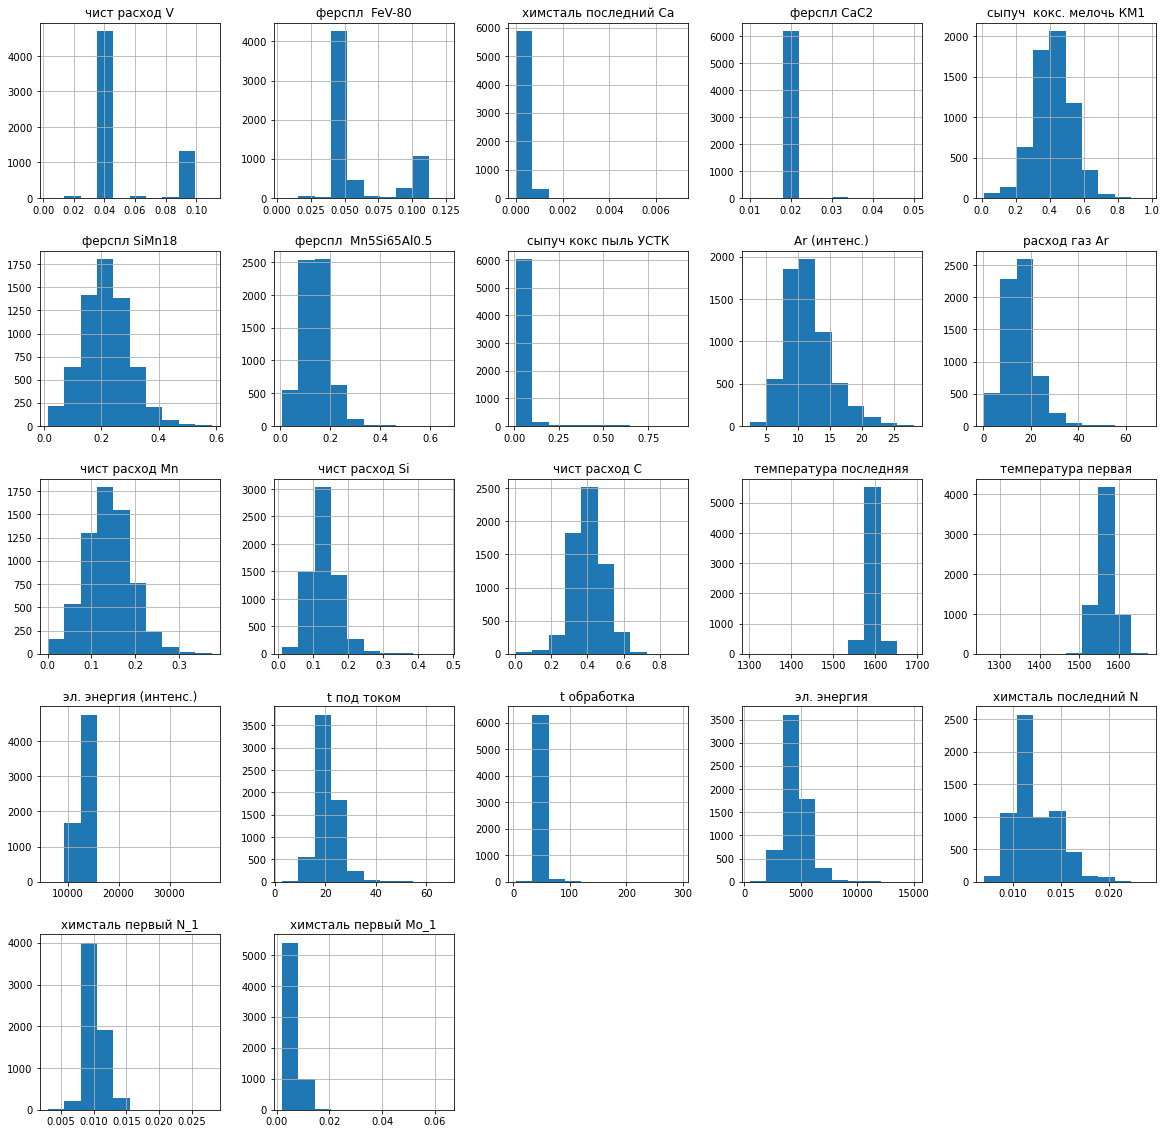

In [48]:
df = data.drop(target_with_nan_col, axis=1).isna().sum().sort_values(ascending=False)
df = df[df != 0]
data[df.index].hist(figsize=(20,20));

In [49]:
# заполним пропуски этих переменных медианой всего признака, так как отсвует меньше 5 % данных для них
# и распредления либо симметричны, либо с выраженным пиком
data[df.index] = data[df.index].apply(lambda x : x.fillna(x.median()))

### Удаление неинформативных признаков

In [50]:
# Нормирование и вариативность признаков
scaler = StandardScaler()
scaler.fit(data.iloc[:,1:])
feature_selection = scaler.transform(data.iloc[:,1:])
# data.iloc[:, 1: ] = feature_selection
std_df = pd.DataFrame(feature_selection, columns=data.iloc[:, 1:].columns).std()
std_df.sort_values(ascending=True)

произв количество плавок (цел)    0.000000
произв  количество плавок         0.000000
сыпуч кокс пыль УСТК              1.000078
химсталь первый Ti_1              1.000078
химсталь первый V_1               1.000078
                                    ...   
ферспл CaC2                       1.000078
химшлак первый Al2O3_1            1.000105
химшлак последний Al2O3           1.000105
химшлак последний SiO2            1.000105
химшлак первый SiO2_1             1.000105
Length: 69, dtype: float64

In [51]:
data.drop(['произв количество плавок (цел)', 'произв  количество плавок'], inplace=True, axis=1)

## Восстановление SiO2 и Al2O3

In [52]:
columns = ['химшлак первый Al2O3_1',
       'химшлак первый CaO_1', 'химшлак первый FeO_1', 'химшлак первый MgO_1',
       'химшлак первый MnO_1', 'химшлак первый R_1', 'химшлак первый SiO2_1',
       'химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2']
# sns.pairplot(data[columns])
plt.show();

<AxesSubplot:>

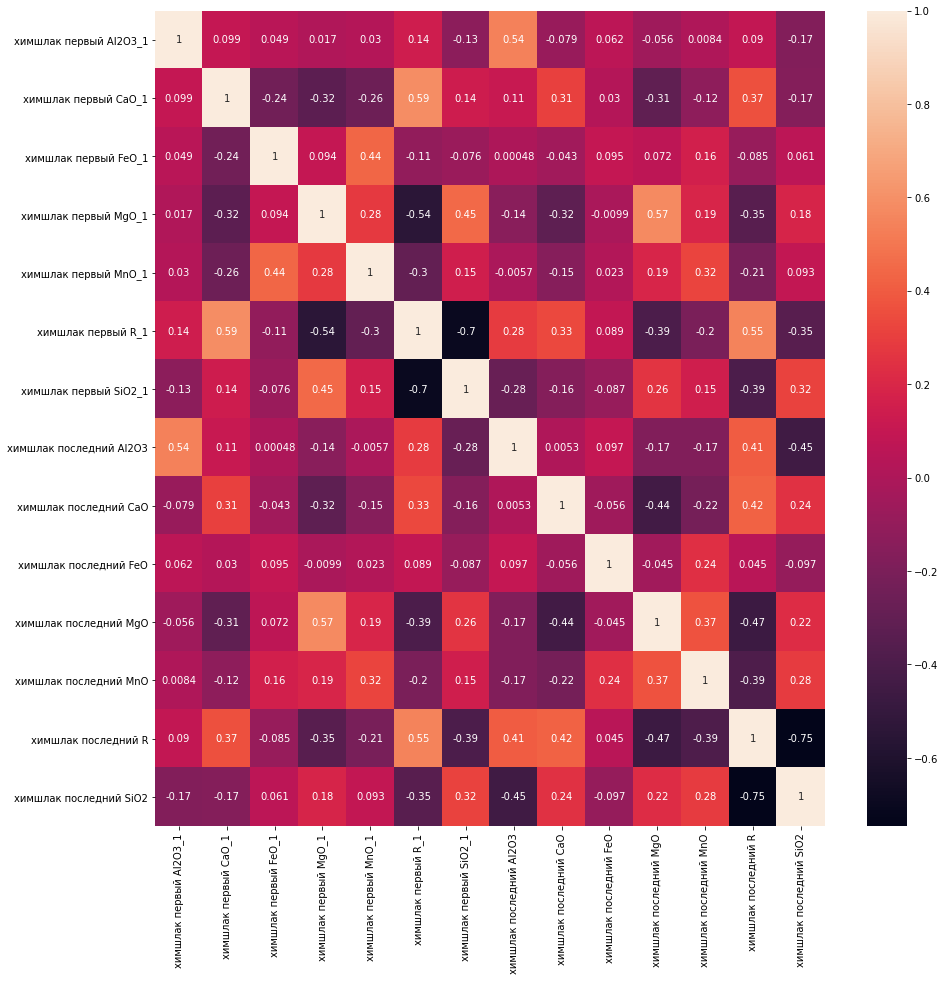

In [53]:
corr_for_target = data[columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_for_target, annot=True)

In [54]:
columns = ['химшлак первый Al2O3_1',
       'химшлак первый CaO_1', 'химшлак первый FeO_1', 'химшлак первый MgO_1',
       'химшлак первый MnO_1', 'химшлак первый R_1', 'химшлак первый SiO2_1',
       'химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2']
# sns.pairplot(data[columns])
plt.show();

In [55]:
# Проверим, что коэффиценты корреляции по модулю больше 1.5 статистически значимы
real_corr = []
for k, i in enumerate(columns):
    for j in columns[k + 1:]:
        df = data[[i, j]].dropna()
        corr = pearsonr(df[i].to_numpy(), df[j])
        if  (corr[1] > 0.05) and (corr[0] > 0.15) :  
            print(i , j, corr)

### Наибольшие коэффиценты корреляции между переменными химшлаков

In [56]:
target_name = []
target_corr = []
corr = []
for name in columns:
    df = np.abs(corr_for_target[name]).sort_values(ascending=False)
    target_name.append(name)
    target_corr.append(df.index[1])
    corr.append(round(corr_for_target.loc[name, df.index[1]], 3))
target_corr_df = pd.DataFrame({'target' : target_name, 'corr_target': target_corr, 'corr' : corr})
target_corr_df

,target,corr_target,corr
0,химшлак первый Al2O3_1,химшлак последний Al2O3,0.540
1,химшлак первый CaO_1,химшлак первый R_1,0.591
2,химшлак первый FeO_1,химшлак первый MnO_1,0.438
3,химшлак первый MgO_1,химшлак последний MgO,0.572
4,химшлак первый MnO_1,химшлак первый FeO_1,0.438
5,химшлак первый R_1,химшлак первый SiO2_1,-0.702
6,химшлак первый SiO2_1,химшлак первый R_1,-0.702
7,химшлак последний Al2O3,химшлак первый Al2O3_1,0.540
8,химшлак последний CaO,химшлак последний MgO,-0.440
9,химшлак последний FeO,химшлак последний MnO,0.240


Из таблицы выше видно, что химшлаки SiO2 можно восстановить по химшлакам R, однако наибольние коэффиценты корреляции у химшлаков Al2O3 между собой, значит для восстановления будем использовать следующий химшлак, значения которого линейно зависимы с Al2O3 - это химшлак R.

In [57]:
# sns.pairplot(data[['химшлак первый Al2O3_1', 'химшлак первый R_1', 'химшлак первый SiO2_1',
#        'химшлак последний Al2O3', 'химшлак последний R', 'химшлак последний SiO2']])

In [58]:
def linear_prediction(X, y):
    X = pd.get_dummies(X, drop_first=True)
    x_train = X[~Y.isna()].to_numpy()
    y_train = Y[~Y.isna()]
    x_test = X[Y.isna()].to_numpy()
    lr = LinearRegression()
    print('среднеквадратичная ошибка регресионной модели:', \
          -round(cross_val_score(lr, x_train, y_train, scoring='neg_mean_squared_error').mean(), 2), '\n')
    lr.fit(x_train, y_train)
    return lr.predict(x_test)

    

In [59]:
data['isna_SiO2'] = data['химшлак последний SiO2'].isna()
data['isna_Al2O3'] = data['химшлак последний Al2O3'].isna()

In [60]:
for target in ['химшлак последний SiO2', 'химшлак первый SiO2_1']:
    print('\nДо заполнения пропусков:')
    brief_summary(data[target])
    target_line = target_corr_df[target_corr_df.target == target]
    X = data.drop(target_with_nan_col, axis=1)
    Y = data[target]
    data[target][Y.isna()] = linear_prediction(X, Y)
    print('После заполнения пропусков:')
    brief_summary(data[target])
    
for target, corr_target in zip(['химшлак первый Al2O3_1',  'химшлак последний Al2O3'] ,[ 'химшлак первый R_1', 'химшлак последний R']):
    print('\nДо заполнения пропусков:')
    brief_summary(data[target])
    X = data.drop(target_with_nan_col, axis=1)
    Y = data[target]
    data[target][Y.isna()] = linear_prediction(X, Y)
    print('После заполнения пропусков:')
    brief_summary(data[target])


До заполнения пропусков:
химшлак последний SiO2 
Медиана: 24.4, Среднее значение: 23.971, Ср.откл:2.188
среднеквадратичная ошибка регресионной модели: 0.28 

После заполнения пропусков:
химшлак последний SiO2 
Медиана: 24.6, Среднее значение: 24.124, Ср.откл:2.174

До заполнения пропусков:
химшлак первый SiO2_1 
Медиана: 22.7, Среднее значение: 22.704, Ср.откл:2.394
среднеквадратичная ошибка регресионной модели: 0.57 

После заполнения пропусков:
химшлак первый SiO2_1 
Медиана: 22.9, Среднее значение: 22.778, Ср.откл:2.31

До заполнения пропусков:
химшлак первый Al2O3_1 
Медиана: 4.0, Среднее значение: 4.114, Ср.откл:0.928
среднеквадратичная ошибка регресионной модели: 0.69 

После заполнения пропусков:
химшлак первый Al2O3_1 
Медиана: 4.065500542668186, Среднее значение: 4.114, Ср.откл:0.835

До заполнения пропусков:
химшлак последний Al2O3 
Медиана: 4.5, Среднее значение: 4.598, Ср.откл:0.96
среднеквадратичная ошибка регресионной модели: 0.65 

После заполнения пропусков:
химшлак по

Видим, что заполнение пустых значений не сильно изменило параметры распредлений данных химшлаков 

In [61]:
data.shape

(6443, 70)

## Выбросы

In [62]:
# удаление выбросов
out_forest = IsolationForest(n_estimators=100, max_features=69, n_jobs=-1, contamination=0.1)
out_forest.fit(data.iloc[:, 1:])
outlier_predicted = out_forest.predict(data.iloc[:, 1:])

ready_df = data.loc[outlier_predicted == 1, :].copy()
ready_df.shape
# (outlier_predicted == 1).sum()

(5798, 70)

In [63]:
# description(ready_df.iloc[:, 1:-2], ready_df.columns[1:-2])

## Отбор признаков

In [64]:
target_columns = ['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2', 'isna_SiO2', 'isna_Al2O3']

target = ready_df[target_columns]
X = ready_df.drop(['химшлак последний Al2O3', 'химшлак последний CaO',
       'химшлак последний FeO', 'химшлак последний MgO',
       'химшлак последний MnO', 'химшлак последний R',
       'химшлак последний SiO2'], axis=1)

scaler = StandardScaler()
scaler.fit(X.iloc[:, 1:-2])
feature_selection = scaler.transform(X.iloc[:,1:-2])
X.iloc[:, 1:-2] = feature_selection

In [65]:
target.to_csv('data/target_data')

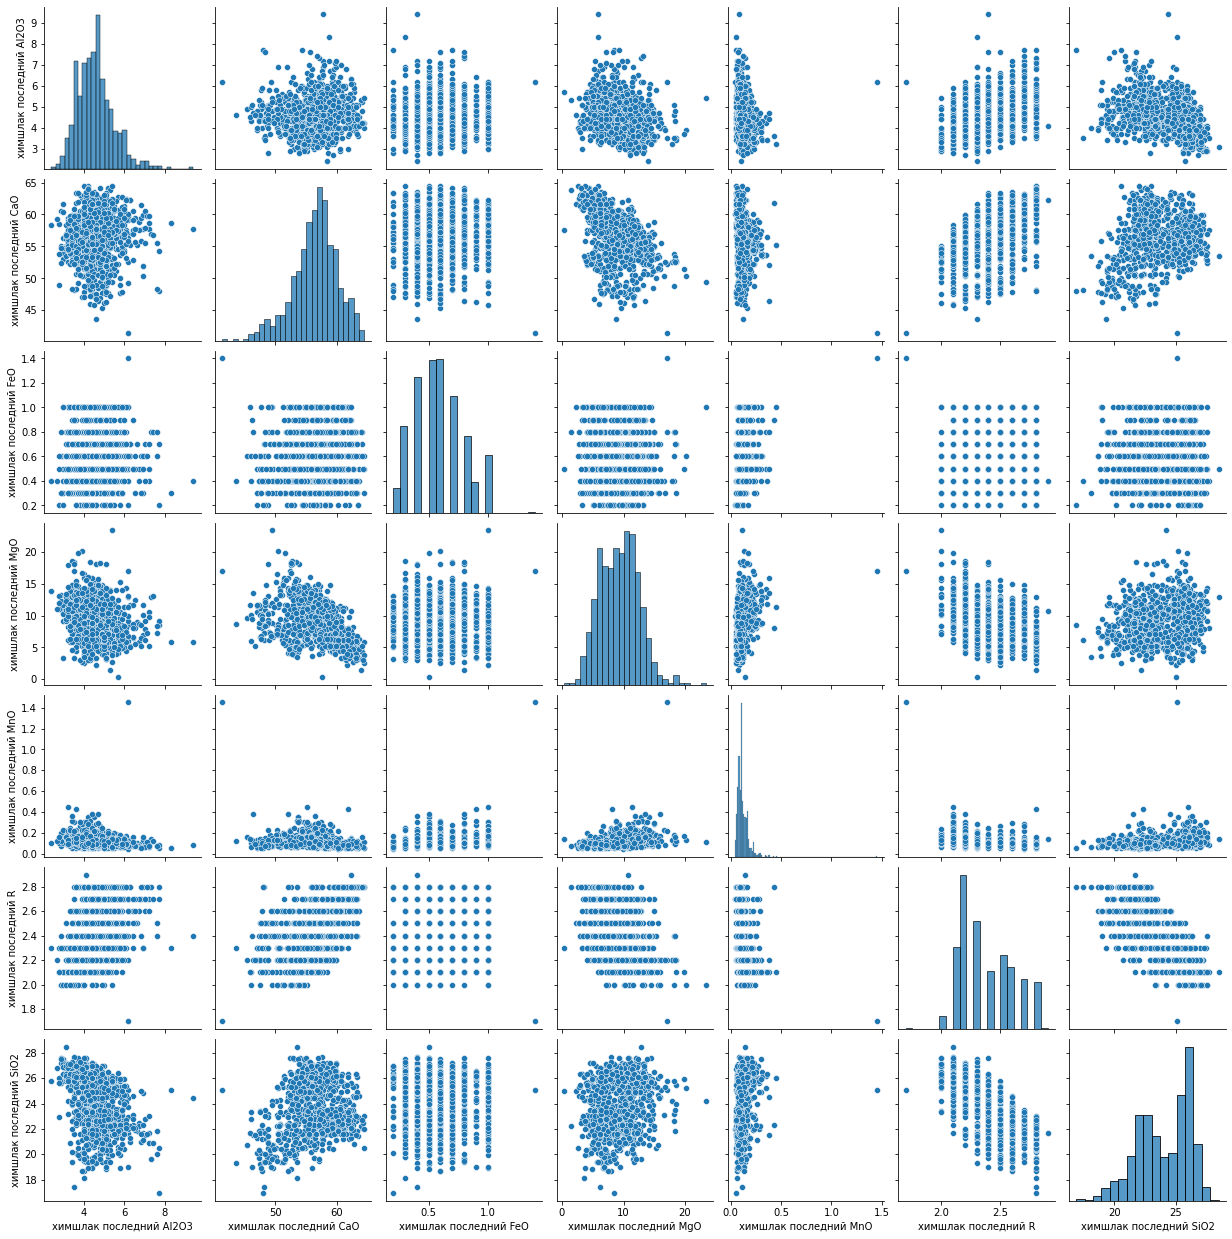

In [78]:
# Посмотрим на зависимости между целевыми переменными графически. Данных около 6000,
# поэтому для более ясной картины я выберу 1000 случайны 1000 строк.
random_samples = random.sample(target[~target.isna_SiO2].index.to_list(), 1000)
sns.pairplot(target.loc[random_samples, target.columns[:-2]])

<AxesSubplot:>

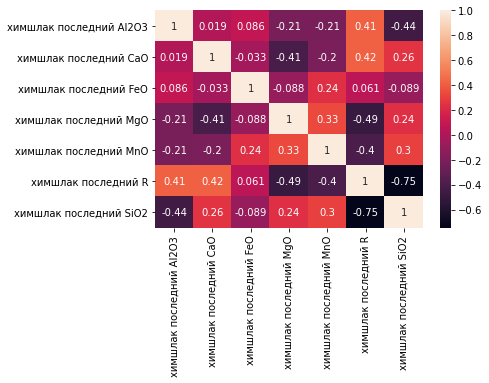

In [67]:
sns.heatmap(target[~target.isna_SiO2].iloc[:, :-2].corr(), annot=True)

Гипотеза: целевые переменные можно восстановить с помощью других целевых переменных:

Al2O3 <- R (corr = 0.42) или Al2O3 <- (corr = -0.44)

SiO2 <- R (corr = -0.75)

CaO <- MgO <- R // CaO <- MgO (corr = -0.41), MgO <- R (corr = -0.49)

*CaO <- R // (corr = -0.41)

FeO <- MnO <- R //  FeO <- MnO (corr = 0.25), MnO <- R (corr = -0.4)

По графикам распредлений видно, что R и FeO имеют дискретное распредление, возможно предсказания через них будут не очень точными. Дополнительно для восстановления других переменных через них надо использовать переменные c непрерывным рапределением.

Графичеcки я вижу среди непрерывных распределений линейную зависимость между CaO и MgO, CaO и SiO2

Гипотеза: Для FeO и R использовать классификацию, а не регрессию.

In [68]:
# target['химшлак последний FeO'].value_counts()

In [69]:
X.shape

(5798, 63)

In [70]:
X = pd.get_dummies(X, drop_first=True)
X.shape

(5798, 64)

In [71]:
def cross_val_check_with_target_nan(y_df, X_df, model):
    for name in y_df.columns[:-2]:    
        y = y_df[name] 
        x = X_df
        print(name, 'r2:', round(cross_val_score(model, x, y, cv=5).mean(),4))
        

def cross_val_check_without_target_nan(y_df, X_df, model):
    for name in y_df.columns[:-2]:    
        y = y_df[target.isna_Al2O3 == False][name] 
        x = X_df.loc[X_df.isna_Al2O3 == False].drop(['isna_Al2O3', 'isna_SiO2'], axis=1)
        print(name, 'r2:', round(cross_val_score(model, x, y, cv=5).mean(),4))


In [72]:
# По результат линейной регрессии определяем, 
# какой порог коэффицента корреляция выбрать для удаления линейно зависимых признаков

for C in np.linspace(0.5, 1, 6):
    temp_df = abs(X.iloc[:, :-3].corr()) > C
    maybe_remove_col = []
    for k, i in enumerate(temp_df.columns.to_list()):
        for j in temp_df.columns.to_list()[k + 1 :]:
            if temp_df.loc[j, i] :
    #             print(i, j)
                maybe_remove_col.append(i)
    maybe_remove_col = set(maybe_remove_col)
    print('\nПри пороговом знаяении корреляции между признаками', C, 'удалим', len(maybe_remove_col), 'признаков\n')
    
#     print('Линейная регрессия по всем признакам, которые остались')
#     cross_val_check_with_target_nan(target, X.drop(maybe_remove_col, axis=1), LinearRegression())
    print('\nЛинейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2')
    cross_val_check_without_target_nan(target, X.drop(maybe_remove_col, axis=1), LinearRegression())


При пороговом знаяении корреляции между признаками 0.5 удалим 29 признаков


Линейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2
химшлак последний Al2O3 r2: 0.3916
химшлак последний CaO r2: -0.0128
химшлак последний FeO r2: 0.0061
химшлак последний MgO r2: -0.0338
химшлак последний MnO r2: 0.0314
химшлак последний R r2: 0.0603
химшлак последний SiO2 r2: 0.1058

При пороговом знаяении корреляции между признаками 0.6 удалим 24 признаков


Линейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2
химшлак последний Al2O3 r2: 0.3965
химшлак последний CaO r2: 0.1216
химшлак последний FeO r2: 0.0143
химшлак последний MgO r2: 0.2703
химшлак последний MnO r2: 0.0247
химшлак последний R r2: 0.2319
химшлак последний SiO2 r2: 0.1321

При пороговом знаяении корреляции между признаками 0.7 удалим 18 признаков


Линейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и

In [73]:
features_corr = X.iloc[:, :-3].corr()
temp_df = abs(features_corr) > 0.9
maybe_remove_col = []
for k, i in enumerate(temp_df.columns.to_list()):
    for j in temp_df.columns.to_list()[k + 1 :]:
        if temp_df.loc[j, i] :
#             print(i, j, round(features_corr.loc[j, i], 2))
            maybe_remove_col.append(i)
maybe_remove_col = set(maybe_remove_col)
print('Выбрали пороговое значение корреляции между признаками:', 0.9, '\nудалим', len(maybe_remove_col), 'признаков')
print(maybe_remove_col)

print('\nЛинейная регрессия по всем признакам, которые остались')
cross_val_check_with_target_nan(target, X.drop(maybe_remove_col, axis=1), LinearRegression())
print('\nЛинейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2')
cross_val_check_without_target_nan(target, X.drop(maybe_remove_col, axis=1), LinearRegression())

Выбрали пороговое значение корреляции между признаками: 0.9 
удалим 14 признаков
{'ферспл  FeV-80', 'химсталь первый Mo_1', 'чист расход V', 't под током', 'химсталь первый Cr_1', 'чист расход Mn', 'химсталь первый Ni_1', 'химсталь последний C', 'чист расход C', 't обработка', 'чист расход Si', 'химсталь первый Cu_1', 'чист расход Cr', 'химсталь первый P_1'}

Линейная регрессия по всем признакам, которые остались
химшлак последний Al2O3 r2: 0.4596
химшлак последний CaO r2: 0.159
химшлак последний FeO r2: 0.016
химшлак последний MgO r2: 0.2934
химшлак последний MnO r2: 0.0898
химшлак последний R r2: 0.2529
химшлак последний SiO2 r2: 0.1298

Линейная регрессия по всем признакам, которые остались + без строк, где не было значений Al2O3 и SiO2
химшлак последний Al2O3 r2: 0.4031
химшлак последний CaO r2: 0.1346
химшлак последний FeO r2: 0.0131
химшлак последний MgO r2: 0.3038
химшлак последний MnO r2: 0.0741
химшлак последний R r2: 0.2606
химшлак последний SiO2 r2: 0.1357


In [74]:
ready_df.to_csv('data/clean_df.csv')
ready_df.shape # датасет с признаками и целевыми переменными

(5798, 70)

In [75]:
X_without_ld = X.drop(maybe_remove_col, axis=1)
X_without_ld.shape

(5798, 50)

In [76]:
X.to_csv('data/features_data.csv')
X_without_ld.to_csv('data/features_data_without_ld.csv')

### Отчет

1. Из 18 марок сталей сформировали 3 класса: Э76ХФ, Э90ХАФ и Другие - объединение остальных классов, чтобы сделать менее не сбалансированную выборку

2. Удалили неинформативные признаки и признаки с более 70 % пропусками (16 колонок): 

    'nplv', 'DT', 'ПРОФИЛЬ' - не имеют отношение к задаче

    'произв количество плавок (цел)', 'произв  количество плавок' - нулевая дисперсия

    'ПСН гр.' - линейно зависимые с переменными энергии 

    'N2 (интенс.)', 'расход газ  N2', 'расход C пров.', 'сыпуч кварцит', 'сыпуч  кокс. мелочь (сух.)', 'ферспл FeMo', 'ферспл FeSi-75', 'ферспл FeV азот.', 'ферспл  Ni H1 пласт.', 'ферспл  ферванит' - переменные, в которых отсутсвуют более 70 % данных

3. Мы удалили 598 строк, 597 из них - это строки, в которых остуствовали значения 37 признаков, включая целевые переменны. Еще один элемент не имел значения по химпшлаку MnO.


4. 'Cыпуч известь РП' и 'ПСН гр.' не было 25 % данных. 'ферспл фх850А, чист расход Cr, 'сыпуч шпат плав.' не было 8 % данных.	 Восстановили их с помощью внутриклассовой медианы по маркам. Остальные восстановила медианой признака, так как пропусков было меньше 5 % и их распределения были или симметричны, или с ярко выраженным пиком.

5. У двух целевых переменных химшлаки AL2O3 и SiO отсутсвовало 26 % данных. Для них была создана дамми-переменная, чтобы в последуюшем анализе выбирать для каких данных делать предсказание:  целевые переменных только с известными значениями или можно использовать восстановленные данные.

    Пропуски восстонавливала с помощью линейной регрессии по всем остальным признакам с заполнеными пропусками. При восстановлении контролировала параметры распредления и среднеквадратичную ошибку на кросс-валидации, значительных изменений не было.

6. Выбросы удалила с помощью IsolationForest с параметром удаления 10 % данных.

В итоге осталось 5798 строк и 68 столбцов.

7 - целевых переменных

1 - категориальный признак 'МАРКА'


Для последующего анализа рассматривается два датасета, в одном из них остались линейно зависимые признаки с коэффицентом корреляции больше 0.9, из другого такие признаки были удалены (15 признаков).

Для обучения колонка 'МАРКА' была разложена на два столбца с бинарнымии значениями. Так как имеется всего три уникальных значения, столбец идентифицирующий третью марку был удален, чтобы избежать мультиколлинеарности.

Сформирована гипотеза, что некоторые целевые признаки можно предсказать по другим. Графически наблюдается линейная зависимоть между CaO и MgO. 

По графикам распредлений видно, что R и FeO имеют дискретное распредление, возможно для предсказания значений этих переменных стоит использовать классификацию.

Несмотря на дискретное рапределение химшлака R, эта переменная хорошо коррелируют с Al2O3 (corr = -0.75) и остальными, кроме FeO.